# Loading children's speech data

In [1]:
import pandas as pd

data = pd.read_pickle('./asr_data/childrens_speech')
data

,text,audio,file_name
0,three,"[0.009646121, 0.021695968, 0.022539534, 0.0212...",english_children/english_words_sentences/11_M_...
1,ten,"[0.027527185, 0.032552492, 0.012983527, 0.0112...",english_children/english_words_sentences/11_M_...
2,nine,"[-0.03888016, -0.057698667, -0.045864653, -0.0...",english_children/english_words_sentences/11_M_...
3,four,"[0.04435131, 0.06784426, 0.058827527, 0.077713...",english_children/english_words_sentences/11_M_...
4,five,"[0.025824236, 0.029695712, 0.02606499, 0.03642...",english_children/english_words_sentences/11_M_...
...,...,...,...
634,and then they saw two frogs,"[-0.025713801, -0.044510987, -0.041728463, -0....",english_children/english_free_speech/files_cut...
635,but one frog didn't came up,"[0.010593225, 0.016391743, 0.012017116, 0.0188...",english_children/english_free_speech/files_cut...
636,and then they saw little baby frogs,"[0.015749954, 0.023017816, 0.018736875, 0.0202...",english_children/english_free_speech/files_cut...
637,and then all of the frogs was looking,"[-0.050608773, -0.07725125, -0.06856466, -0.07...",english_children/english_free_speech/files_cut...


# Loading transcribed data

The models used here are Whisper (tiny, base, and small) and lthe 960h Large wav2vec2

In [2]:

whisper_tiny = pd.read_pickle('./asr_data/tiny_whisper')
whisper_tiny['model'] = 'whisper_tiny'

whisper_base = pd.read_pickle('./asr_data/base_whisper')
whisper_base['model'] = 'whisper_base'

whisper_small = pd.read_pickle('./asr_data/small_whisper')
whisper_small['model'] = 'whisper_small'

wav2vec2_large_960h = pd.read_pickle('./asr_data/wav2vec_large_960h')
wav2vec2_large_960h['model'] = 'wav2vec2_large_960h'

# From one data frame with all models 
all_models = pd.concat([whisper_tiny, whisper_base, whisper_small, wav2vec2_large_960h], axis=0, ignore_index=True)


# Convert Arabic numbers such as "1" to words one, i.e "one"

In [3]:
num2words = {'1': 'one', '2': 'two', '3': 'three', '4': 'four', '5': 'five',
             '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine', '10': 'ten'}

strings = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
def n2w(n):
    """Convert numbers to words"""
    if n in strings:
        return n
    return num2words[n]


In [4]:
list_of_numbs = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                 '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

for i in all_models.index:
    if 'numbers' in all_models.at[i, 'file_name'] and all_models.at[i, 'hypothesis_clean'] not in list_of_numbs:
        all_models.at[i, 'references_clean'] = all_models.at[i, 'references']
    # if 'number' in str(all_models.at[i, 'file_name']):
    #     print(all_models.at[i, 'references'])
    

    # if 'number' in row['file_name']:
    #     print(all_models.at[i , 'references'])
# all_models[all_models['file_name'].str.contains('number')]


In [5]:
all_models[all_models['file_name'].str.contains('numbers')]


,file_name,hypothesis,references,hypothesis_clean,references_clean,model
5,drive/MyDrive/data/english_children/english_wo...,Free,three,free,three,whisper_tiny
6,drive/MyDrive/data/english_children/english_wo...,ens.,two,ens,two,whisper_tiny
7,drive/MyDrive/data/english_children/english_wo...,9,nine,9,9,whisper_tiny
8,drive/MyDrive/data/english_children/english_wo...,snap,seven,snap,seven,whisper_tiny
9,drive/MyDrive/data/english_children/english_wo...,ory front.,one,ory front,one,whisper_tiny
...,...,...,...,...,...,...
2329,english_children/english_words_sentences/09_F_...,EIGHT,eight,8,8,wav2vec2_large_960h
2330,english_children/english_words_sentences/09_F_...,IX,six,ix,six,wav2vec2_large_960h
2331,english_children/english_words_sentences/09_F_...,OLY,four,oly,four,wav2vec2_large_960h
2332,english_children/english_words_sentences/09_F_...,IVES,five,ives,five,wav2vec2_large_960h


In [6]:
nmbs = whisper_tiny[whisper_tiny['file_name'].str.contains('number')][['references', 'references_clean']]
# nmbs.to_csv(r'numbs.txt', header=None,
#               index=None, sep=' ', mode='a')


# Calculating the Word Error Rates

In [7]:
import jiwer

wers = pd.DataFrame()
wers['model'] = ['whisper_tiny', 'whisper_base',
                 'whisper_small', 'wav2vec2_large_960h']

conditions = ['port', 'studio', 'nao', 'free_speech', 'words_sentence', 'number']

for i, row in enumerate(wers['model']):
    # Mixed data WERs
    subset = all_models[all_models['model'] == row]
    wers.at[i, 'mixed'] = jiwer.wer(list(subset["references_clean"]),
                                    list(subset["hypothesis_clean"]))
    for condition in conditions:
        # Calculate the WERs for all the conditions
        subset = all_models[(all_models['model'] == row ) & (all_models['file_name'].str.contains(condition))]
        if condition == 'words_sentence':
            subset = subset[~subset['file_name'].str.contains('number')]
        wers.at[i, condition] = jiwer.wer(list(subset["references_clean"]),
                                          list(subset["hypothesis_clean"]))
        
      
# print(f"WER: {wer * 100:.2f} %"
wers


,model,mixed,port,studio,nao,free_speech,words_sentence,number
0,whisper_tiny,0.514643,0.426991,0.484444,0.695291,0.507883,0.379939,1.039855
1,whisper_base,0.423824,0.411504,0.437778,0.554017,0.396959,0.306991,1.014493
2,whisper_small,0.318526,0.345133,0.335556,0.443213,0.282095,0.215805,0.920290
3,wav2vec2_large_960h,0.621586,0.539823,0.604444,0.891967,0.591779,0.583587,0.949275


# Calculating the Levenshtein distance 



In [8]:
from Levenshtein import ratio
from Levenshtein import distance
from Levenshtein import hamming
import statistics
lds = pd.DataFrame()
lds['model'] = ['whisper_tiny', 'whisper_base',
                 'whisper_small', 'wav2vec2_large_960h']

conditions = ['port', 'studio', 'nao', 'free_speech', 'words_sentence', 'number']
good_nums =[]
for i, row in enumerate(lds['model']):
    subset = all_models[all_models['model'] == row]
    ld = []
    for j, sub_row in subset.iterrows():
        dist = distance(sub_row["references_clean"],
                        sub_row["hypothesis_clean"])
        ld.append(dist)
    # Get the mean LD
    lds.at[i, 'mixed'] = round(statistics.fmean(ld),2)
 
    for condition in conditions:
        subset = all_models[(all_models['model'] == row) & (
              all_models['file_name'].str.contains(condition))]
        if condition == 'words_sentence':
            subset = subset[~subset['file_name'].str.contains('number')]
        ld = []
        for j, sub_row in subset.iterrows():
            dist = distance(sub_row["references_clean"],
                            sub_row["hypothesis_clean"])
            norm_dist = dist / len(sub_row["references_clean"])
            if condition == 'number' and (0 < dist < 4):
                good_nums.append(
                    (sub_row["hypothesis_clean"], sub_row["references_clean"], dist, row))

            ld.append(dist)
        lds.at[i, condition] = round(statistics.fmean(ld),2)

lds
# print(lds.to_latex(index=False))



,model,mixed,port,studio,nao,free_speech,words_sentence,number
0,whisper_tiny,7.61,4.02,4.66,7.05,12.34,7.69,3.76
1,whisper_base,6.16,3.89,4.04,5.59,9.44,5.85,3.68
2,whisper_small,4.48,3.05,3.07,4.48,6.42,4.02,3.16
3,wav2vec2_large_960h,7.54,3.96,4.69,7.46,11.97,9.65,2.91


In [67]:
total = len([sample[3] == 'whisper_tiny' for sample in good_nums])
counts = pd.DataFrame()
nums = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
for num in nums:
    counts[num] = [sample[1] == num and (sample[3] == 'whisper_tiny') for sample in good_nums]
# (num/total) * 100

[if sample[3] == 'whisper_tiny' print(sample) for sample in good_nums]


[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa

In [10]:
# numbers = whisper_base[whisper_base['file_name'].str.contains('number')][['hypothesis_clean',
#                          'references_clean',]]

# numbers.to_csv('./numbers.txt', index=None)


# On the robustness of the NLU

In [11]:
# from unittest import expectedFailure
import requests
# TODO: include 'negative exmaples'
# Create an empty list to store predictions with size of ASR model predcitons

nlu_performance = pd.DataFrame()
nlu_performance['model'] = ['whisper_tiny', 'whisper_base', 'whisper_small', 'wav2vec2_large_960h']

# NLU endpoint to parse text to intents and entities
url = 'http://localhost:5005/model/parse'

list_of_numbs = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 
                 '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
                 
for i, row in enumerate(nlu_performance['model']):
    numbers = all_models[
        (all_models['model'] == row ) &
        (all_models['file_name'].str.contains('number') )
    ]
    # numbers = numbers[[hypo.lower() not in list_of_numbs for hypo in numbers['hypothesis_clean']]].copy()
    
    # all_tests = pd.concat([numbers, not_numbers], ignore_index=True)
    # preds = [None] * (len(numbers) + len(not_numbers))
    intent_preds = [None] * (len(numbers))
    entity_preds = [None] * (len(numbers))

    for j, row in enumerate(numbers['hypothesis']):

        payload = {
            "text": row
        }
        try:
            responses = requests.post(url, json=payload).json()
          
        except Exception as e:
            print(e)
        intent_preds[j] = responses['intent']['name'] == 'math_game_count'
     
        if responses['entities']:
            # print(responses['entities'])
            entity_preds[j] = any(entity['entity'] == 'math_game_number' for entity in responses['entities'])
        else:
            entity_preds[j] = False
    # print(i)
    nlu_performance.at[i, 'inten_acc'] = round(sum(intent_preds) / len(intent_preds), 2) * 100
    nlu_performance.at[i, 'entity_acc'] = round(sum(entity_preds) / len(entity_preds),2) * 100



nlu_performance



HTTPConnectionPool(host='localhost', port=5005): Max retries exceeded with url: /model/parse (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f94b7ee34c0>: Failed to establish a new connection: [Errno 61] Connection refused'))


NameError: name 'responses' is not defined

In [ ]:
print(list(nlu_performance['inten_acc']))
list(nlu_performance['entity_acc'])

[9.0, 11.0, 9.0, 7.000000000000001]


[8.0, 12.0, 8.0, 6.0]

In [ ]:
# only one count vectoriser
# tiny - base - small - wav2vec2_large_960hd
intent_acc = [3.0, 6.0, 2.0, 4.0]
entity_acc = [3.0, 6.0, 2.0, 0.0]

# Using two CountVectors with min = 1 and max = 2
intent_acc = [7.00, 9.0, 4.0, 4.0]
entity_acc = [8.0, 10.0, 8.0, 2.0]

# Using two CountVectors with min = 1 and max = 3
intent_acc = [6.0, 8.0, 4.0, 6.0]
entity_acc = [8.0, 11.0, 10.0, 7.00]

# Using two CountVectors with min = 1 and max = 4
intent_acc = [9.0, 11.0, 9.0, 7.0]
entity_acc = [8.0, 12.0, 8.0, 6.0]


# Using two CountVectors with min = 1 and max = 5
intent_acc = [9.0, 11.0, 10.0, 10.0]
entity_acc = [8.0, 11.0, 8.0, 5.0]

# Using two CountVectors with min = 1 and max = 6
intent_acc = [4.0, 7.00, 3.0, 4.0]
entity_acc = [5.0, 8.0, 4.0, 1.0]

# Using two CountVectors with min = 2 and max = 4


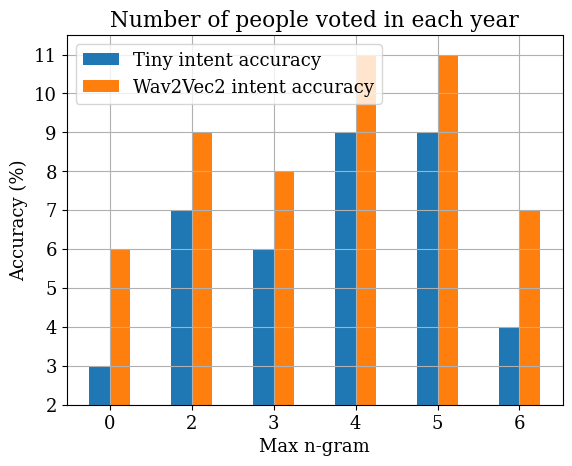

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
tiny_intent_acc = [3, 7, 6, 9, 9, 4]
tiny_entity_acc = [3, 8, 8, 8, 8, 5]
wav2vec2_large_960h_intent_acc = [6, 9, 8, 11,11,7]
Women = [115, 215, 250, 200]
Men = [114, 230, 510, 370]

n = 6
r = np.arange(n)
width = 0.25


plt.bar(r, tiny_intent_acc, 
        width=width,
        label='Tiny intent accuracy')
plt.bar(r + width, wav2vec2_large_960h_intent_acc,
        width=width,
        label='Wav2Vec2 intent accuracy')


plt.xlabel("Max n-gram")
plt.ylabel("Accuracy (%)")
plt.title("Number of people voted in each year")
plt.ylim(2, 11.5)
# plt.grid(linestyle='--')
plt.xticks(r + width/2, ['0', '2', '3', '4', '5', '6'])
plt.yticks(range(2,12))
plt.legend()
plt.grid()

plt.show()
# max_ngrams = [0, 2, 3 ,4 ,5 ,6]
# plt.bar(max_ngrams, tiny_intent_acc, label='Tiny')
# plt.plot(max_ngrams, tiny_entity_acc, '-o')
# plt.bar(max_ngrams, wav2vec2_large_960h_intent_acc  ,label='Wav2Vec2 intent acc.')
# plt.xlabel('Maximum n-gram (min n-gram fixed at 1)')
# plt.ylabel('Accuracy (%)')



In [ ]:
nlu_performance['LD'] = lds['number']
print(nlu_performance.to_latex(index=False))


181

# Plotting figures

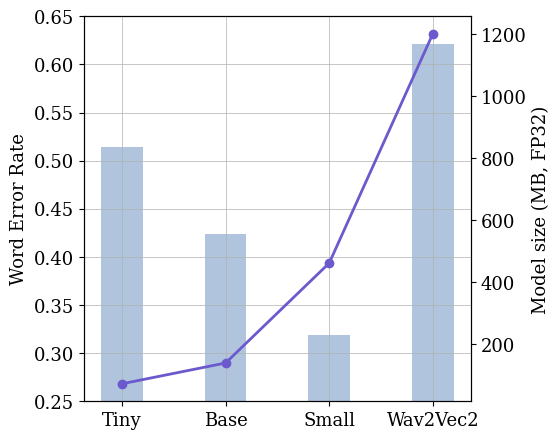

In [34]:
from pyexpat import model
import numpy as np 
import matplotlib.pyplot as plt
#
plt.rcParams.update({'font.size': 13, 'font.family': 'serif'})

X = ['Tiny', 'Base', 'Small', 'Wav2Vec2']
 
 
ld_numbers = lds['number']

model_sizes = [72, 139, 461, 1200]
fig, ax1 = plt.subplots(figsize=(5,5))

X_axis = np.arange(len(X))
ax2 = ax1.twinx()
ax2.plot(X_axis, model_sizes, '-o', linewidth=2, color='slateblue')
# ax1.plot(x, y1, 'g-')
# ax2.plot(x, y2, 'b-')

# ax1.set_xlabel('X data')
ax1.set_ylabel('Word Error Rate')
ax2.set_ylabel('Model size (MB, FP32)')
# ax2.set_yticks(model_sizes)
ax1.set_xticks(X_axis, X)
# ax1.set(aspect=1)

ax1.set_ylim(0.25, 0.65)

# ax1.grid(linestyle='--', linewidth=1)
ax1.bar(X_axis,  wers['mixed'], 0.4,
        label='Word level', color='lightsteelblue')

plt.xlabel("Automatic Speech Recogntion Model")
# plt.ylabel("Normalised LevenShetein Distance")
# plt.title("The Tiny Whisper model's perfomance is on par with Wav2vec2's largest model.\n Both data sets include native and non-native speakers of mean age 4.9 STD = 0.3")
# ax1.legend()
ax1.grid(visible=True, linestyle='-', linewidth=0.5)
plt.show()
fig.savefig('LDS.pdf', bbox_inches='tight')
